In [2]:
import setup
import numpy as np
from matplotlib import pyplot as plt
import importlib
np.set_printoptions(precision=3, suppress=True)
from tight_binding_redweasel import *
from tight_binding_redweasel import qespresso_interface as qe
from tight_binding_redweasel import fermi_surface as fs
importlib.reload(dos);

In [12]:
# my model
tb_nitinol = BandStructureModel.load("bruinsma_improved.json")
#tb_nitinol = BandStructureModel.load("ni.repr")
#tb_nitinol = BandStructureModel.load("ni_asym.repr")
# test symmetry of my model
print(tb_nitinol([[0.1, 0.2, 0.3], [-0.1, -0.2, 0.3]])) # no symmetry... just approximate

# qe data
material = qe.from_disk("nitinol_0K")
k_smpl, ref_bands, symmetries, fermi_energy_qe = material.read_bands_crystal()
all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]
neutral_electrons = 7

[[10.677 12.941 13.263 13.796 13.964 14.206 16.375 16.539 17.123 17.569
  18.3   21.675 25.47  27.73  30.775 36.066 44.292 51.326]
 [10.64  12.914 13.277 13.787 13.935 14.201 16.375 16.536 17.042 17.622
  18.321 21.659 25.554 27.793 30.723 36.059 44.301 51.348]]


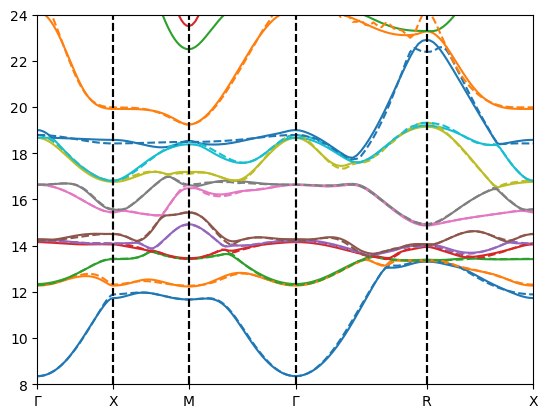

In [13]:
path = kpaths.KPath('G').to('X').to('M').to('G').to('R').to('X')
interpolator = kpaths.interpolate(k_smpl, ref_bands, Symmetry.cubic(True), method='cubic')
path.plot(tb_nitinol, '-')
path.plot(interpolator, '--')
plt.ylim(8, 24)
plt.show()

In [14]:
# naive calcualtion of the Fermi-energy
k_smpl = np.stack(np.meshgrid(*3*(np.linspace(-0.5, 0.5, 32, endpoint=False),)), axis=-1).reshape(-1, 3)
bands = tb_nitinol(k_smpl) # shape = [N_k, N_B]
e_arr = np.sort(bands.ravel()) # Energiewerte sortiert
E_fermi = (e_arr[32**3*7] + e_arr[32**3*7+1]) / 2
print(E_fermi)

16.18780472611893


In [15]:
# improved calculation without symmetry
dos_nitinol = dos.DensityOfStates(tb_nitinol, N=40, ranges=((-0.5, 0.5),)*3, wrap=True)
fermi_energy = dos_nitinol.fermi_energy(neutral_electrons)
print(fermi_energy)

16.185895997742275


In [8]:
# with (some) symmetry
e_list = []
N_smpl = np.array([10, 11, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34])
for N in N_smpl:
    dos_nitinol = dos.DensityOfStates(tb_nitinol, N=N, ranges=((0.0, 0.5),)*3, wrap=False)
    fermi_energy = dos_nitinol.fermi_energy(neutral_electrons)
    e_list.append(fermi_energy)
e_list = np.array(e_list)

[-0.359 16.191]
16.19089±0.00014


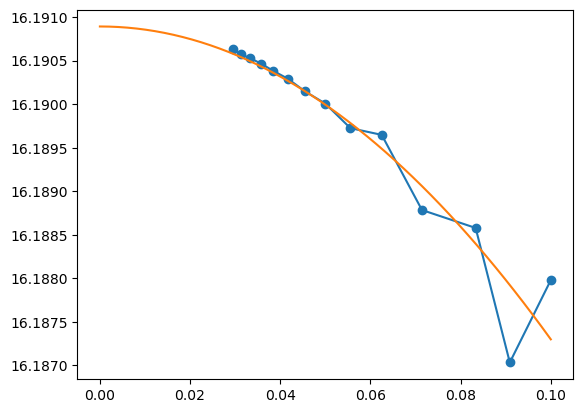

[ 0.299 -1.927]


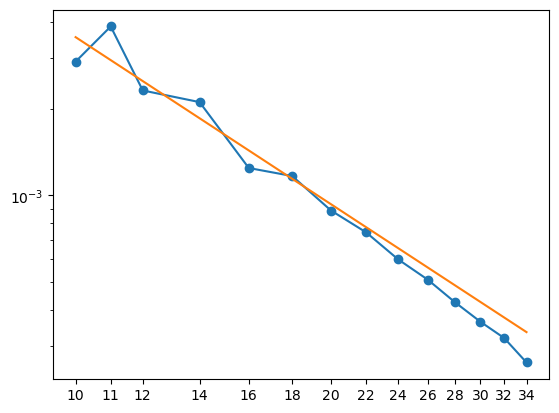

In [9]:
from scipy.optimize import curve_fit

# plot error to extrapolated value
def fit_extrapolate(x, a, b):
    return a * x**2 + b
popt, pcov = curve_fit(fit_extrapolate, 1/N_smpl, e_list)
print(popt)
best_fermi_energy = popt[1]#e_list[-1]#popt[1]
print(f"{best_fermi_energy:.5f}±{pcov[1,1]**.5:.5f}")
# extrapolate using this:
plt.plot(1/N_smpl, e_list, 'o-')
h_smpl = np.linspace(0, 0.1)
plt.plot(h_smpl, fit_extrapolate(h_smpl, *popt), label="fit")
plt.show()

# plot error to extrapolated value
def fit(x, a, b):
    return a * x**b
popt, pcov = curve_fit(fit, N_smpl, np.abs(e_list - best_fermi_energy))
print(popt)
plt.loglog(N_smpl, np.abs(e_list - best_fermi_energy), 'o-')
plt.loglog(N_smpl, fit(N_smpl, *popt), '-')
plt.xticks(N_smpl, [str(N) for N in N_smpl])
plt.show()

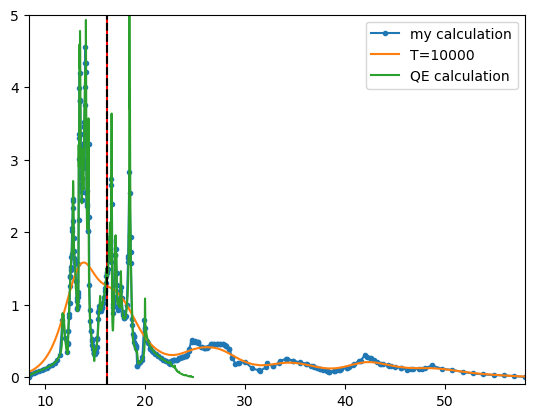

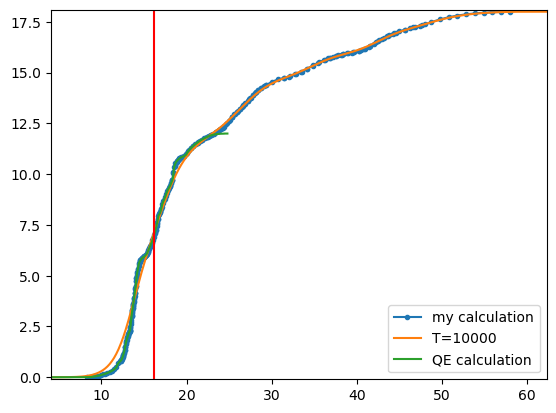

In [16]:
# read the data from Bandx.dat from Quantum Espresso
(energy_smpl2, density2, states2), fermi_energy2 = material.read_dos() # Diese Rechnung hat 20min gebraucht!
energy_smpl, states, density = dos_nitinol.full_curve(N=20)
T = 10000 # K
energy_smpl_T, states_T, density_T = dos_nitinol.full_curve(N=20, T=T)
plt.plot(energy_smpl, density, '.-', label="my calculation")
plt.plot(energy_smpl_T, density_T, '-', label=f"T={T}")
plt.axvline(fermi_energy, color='r')
plt.plot(energy_smpl2, density2/2, '-', label="QE calculation")
plt.axvline(fermi_energy, color='k', linestyle="dashed")
plt.ylim(-0.1, 5)
plt.xlim(np.min(energy_smpl), np.max(energy_smpl))
plt.legend()
plt.show()
plt.plot(energy_smpl, states, '.-', label="my calculation")
plt.plot(energy_smpl_T, states_T, '-', label=f"T={T}")
plt.plot(energy_smpl2, states2/2-8, '-', label="QE calculation")
plt.axvline(fermi_energy, color='r')
plt.ylim(-0.1, dos_nitinol.model_bandcount()+0.1)
plt.xlim(np.min(energy_smpl_T), np.max(energy_smpl_T))
plt.legend()
plt.show()

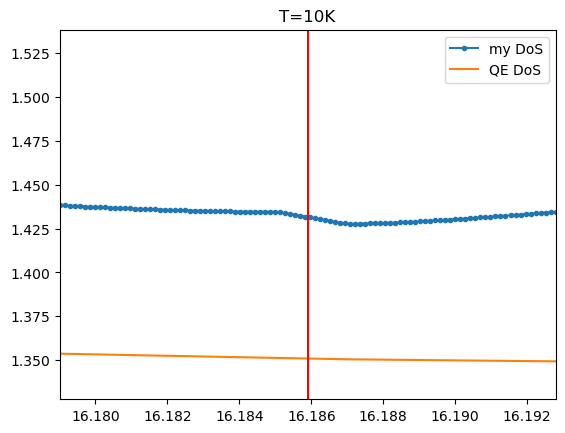

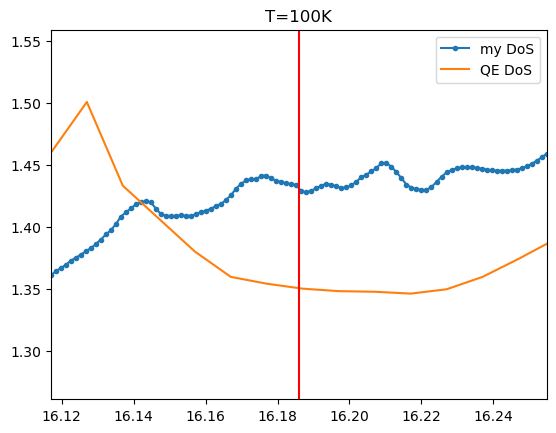

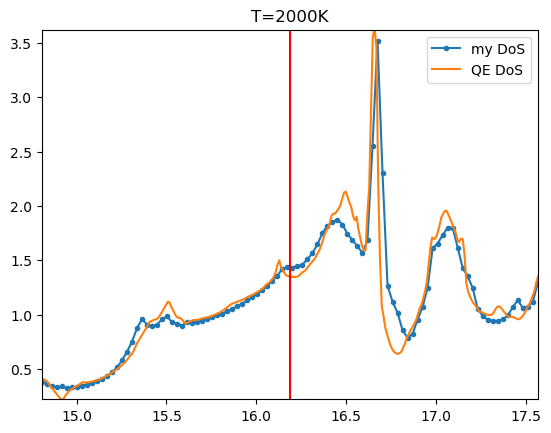

In [17]:
dos_nitinol = dos.DensityOfStates(tb_nitinol, N=24, ranges=((0.0, 0.5),)*3, wrap=False)
for T in [10, 100, 2000]:
    k_B = 8.61733326214518e-5 # eV/K
    beta = 1 / (k_B * T) # 1/eV
    delta = 8 / beta
    energy_smpl = np.linspace(fermi_energy - delta, fermi_energy + delta, 100)
    density = [dos_nitinol.density(e) for e in energy_smpl]
    plt.plot(energy_smpl, density, '.-', label="my DoS")
    plt.plot(energy_smpl2, density2/2, '-', label="QE DoS")
    plt.axvline(fermi_energy, color='r')
    #plt.vlines(np.ravel(dos_nitinol.bands_range), 0.5, 3.7, color='k', linestyle="dashed")
    plt.xlim(fermi_energy - delta, fermi_energy + delta)
    plt.ylim(np.min(density)-0.1, np.max(density)+0.1)
    plt.title(f"T={T}K")
    plt.legend()
    plt.show()

/media/Daten/userfiles/Dokumente/Studium/Semester9/Masterarbeit/code/library/notebooks/../src/tight_binding_redweasel/density_of_states.py:475: RuntimeWarning: overflow encountered in exp
  energy_smpl = np.log(1 / (1e-16 + np.linspace(1/(1 + np.exp(beta*(e0-fermi_energy))), 1/(1 + np.exp(beta*(e1-fermi_energy))), N)) - 1 + 1e-16) / beta + fermi_energy
/media/Daten/userfiles/Dokumente/Studium/Semester9/Masterarbeit/code/library/notebooks/../src/tight_binding_redweasel/density_of_states.py:167: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(beta*e)) # overflows can be safely ignored here!


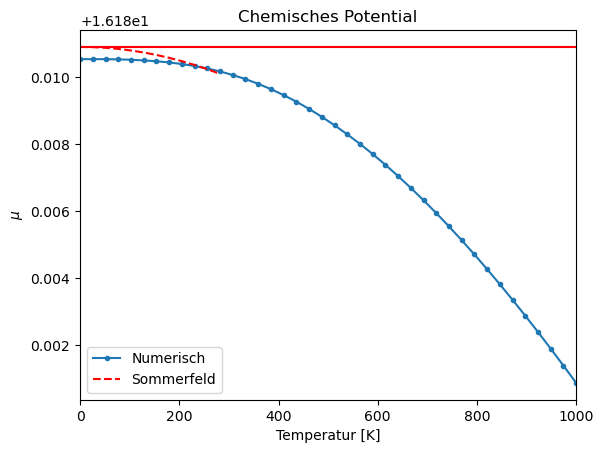

In [18]:
dos_nitinol = dos.DensityOfStates(tb_nitinol, N=30, ranges=((0.0, 0.5),)*3, wrap=False) # assume symmetry
fermi_energy = best_fermi_energy
# plot chemical potential in dependence of T

# new method using exact convolution of states
T_smpl = np.linspace(0, 1000, 40)
mu_list = dos_nitinol.chemical_potential(neutral_electrons, T_smpl, N=40, tol=1e-8, maxsteps=50)
e0, e1 = dos_nitinol.energy_range()
T_lin = 0.25*0.25*2/dos.k_B*max(abs(e0-fermi_energy), abs(e1-fermi_energy))
plt.plot(T_smpl, mu_list, '.-', label="Numerisch")

# analytical expectation
plt.axhline(fermi_energy, color="r")
h = 1e-3
drho = (dos_nitinol.density(fermi_energy + h) - dos_nitinol.density(fermi_energy - h)) / 2 / h
rho = dos_nitinol.density(fermi_energy)
plt.plot(T_smpl[T_smpl<300], fermi_energy - drho/rho*np.pi**2/6*dos.k_B**2*T_smpl[T_smpl<300]**2, 'r--', label="Sommerfeld")
plt.plot(T_smpl[T_smpl>T_lin], np.mean(dos_nitinol.bands) - dos.k_B*T_smpl[T_smpl>T_lin]*np.log(len(ref_bands[0])/neutral_electrons-1), color="g")

plt.xlim(np.min(T_smpl), np.max(T_smpl))
plt.title("Chemisches Potential")
plt.ylabel("$\\mu$")
plt.xlabel("Temperatur [K]")
plt.legend()
plt.show()

In [ ]:
fermi_energy = 16.157
dos_nitinol = dos.DensityOfStates(tb_nitinol, N=32, ranges=((0.0, 0.5),)*3, wrap=False)
#dos_nitinol = dos.DensityOfStates(tb_nitinol, N=24, ranges=((-0.5, 0.5),)*3)

points, indices, weights, area = dos_nitinol.fermi_surface_samples(fermi_energy, improved_points=True)
print(area, "<", 8 * len(points) * (0.5/32)**2 * 3/4*3**.5)
#assert abs(area - dos_nitinol.density(fermi_energy)) < 1e-5
weights *= len(weights) * area # should be in [0, 1.3]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# plot only the errors...
select = np.min(np.abs(tb_nitinol(points) - fermi_energy), axis=-1) < 1e-2
orig_points_len = len(points)
points = points[select]; weights = weights[select]
print(f"{len(points)}/{orig_points_len}")
cmap = ax.scatter(points[:,0], points[:,1], points[:,2], c=weights)
ax.set_xlim(0.0, 0.5)
ax.set_ylim(0.0, 0.5)
ax.set_zlim(0.0, 0.5)
ax.set_aspect("equal")
#ax.view_init(elev=30, azim=-110)
ax.view_init(elev=2, azim=-90)
plt.colorbar(cmap)
plt.show()